# Modeling retinal response variability

Attempt to use simple models to show how the retina transforms a visual input into the variable responses of retinal ganglion cells.

In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import h5py
from scipy.stats import zscore, norm, pearsonr, poisson
from scipy.optimize import curve_fit
from pyret.spiketools import binspikes
from pyret.filtertools import getsta, decompose
from pyret.nonlinearities import Binterp
# from deepretina.toolbox import load_model, load_partial_model, rolling_window
# from deepretina.io import despine
# from deepretina.metrics import cc

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

You must install GPy (pip install GPy) to fit the GP regression nonlinearity.


## Helper aesthetics functions

In [2]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

# Retina schematic  
Highlighting retinal ganglion cells, the output cells of the retina.

![title](img/ganglion_cell_cartoon.png)

# Modeling retinal responses with linear-nonlinear model

## Load retinal responses to a spatiotemporal white noise stimuli

In [3]:
test_set_size = 6000
sample_rate = 100.
with h5py.File('data/whitenoise.h5', 'r') as h:
    # train set
    whitenoise_stimulus = np.array(h['test/stimulus'][:-test_set_size])
    whitenoise_response = np.stack([np.array(h['test/repeats/%s' %key][:,:-test_set_size]) for key in sorted(h['test/repeats'].keys())])
    whitenoise_psth = np.array(h['test/response/firing_rate_10ms'][:,:-test_set_size])
    time = np.array(h['test/time'][:-test_set_size])
    
    # test set
    test_whitenoise_stimulus = np.array(h['test/stimulus'][-test_set_size:])
    test_whitenoise_response = np.stack([np.array(h['test/repeats/%s' %key][-test_set_size:]) for key in sorted(h['test/repeats'].keys())])
    test_whitenoise_psth = np.array(h['test/response/firing_rate_10ms'][:, -test_set_size:])
    test_time = np.array(h['test/time'][-test_set_size:])

In [4]:
whitenoise_stimulus.shape

(24011, 50, 50)

In [5]:
print('Each repeat is %0.1f minutes long, at a %0.1f Hz sampling rate.' %(whitenoise_stimulus.shape[0]/(sample_rate*60.), sample_rate))

Each repeat is 4.0 minutes long, at a 100.0 Hz sampling rate.


In [6]:
print(whitenoise_response.shape)
print('There are %d cells and %d repeats.' %(whitenoise_response.shape[:2]))

(28, 2, 24011)
There are 28 cells and 2 repeats.


## Visualize the data

#### First repeat of white noise

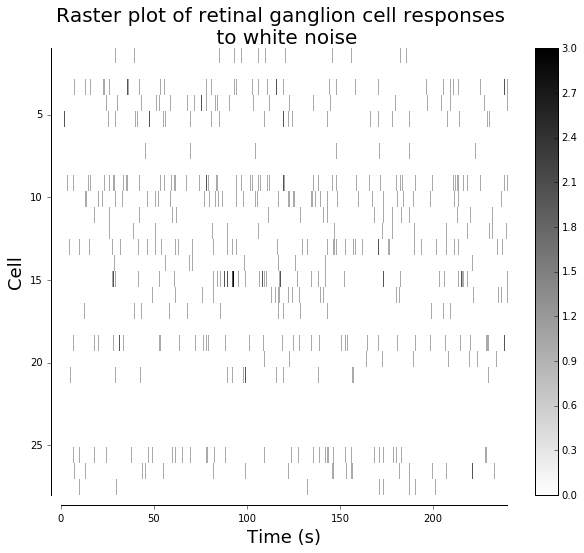

In [7]:
plt.imshow(whitenoise_response[:,0,:], aspect='auto', cmap='gray_r', extent=(time[0], time[-1], whitenoise_response.shape[0], 1))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Cell', fontsize=18)
plt.title('Raster plot of retinal ganglion cell responses \n to white noise', fontsize=20)
plt.colorbar()
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

Which cell has the most number of spikes?

In [8]:
most_spiking_cell = np.argmax(np.sum(whitenoise_response[:,0,:], axis=1))
most_spikes = np.sum(whitenoise_response[:,0,:], axis=1)[most_spiking_cell]
print('Cell %d has the highest firing rate at %0.2f Hz' %(most_spiking_cell, 
                                                          most_spikes/(whitenoise_stimulus.shape[0]/sample_rate)))
mean_spikes = np.mean(np.sum(whitenoise_response[:,0,:], axis=1))
print('Mean spike rate is %0.2f Hz' %(mean_spikes/(whitenoise_stimulus.shape[0]/sample_rate)))

Cell 14 has the highest firing rate at 14.19 Hz
Mean spike rate is 3.75 Hz


Let's analyze what cell 14 is doing.

## Linear input-output relationship of a cell

In [9]:
spike_times = [time[t] for t,r in enumerate(whitenoise_response[most_spiking_cell,0]) if r>0]

In [10]:
# getsta takes (time, stimulus, spikes, filter_length in frames)
filter_length = 40 # at 100 Hz, 40 frames is 0.4 seconds (400 milliseconds)
zscored_stimulus = zscore(whitenoise_stimulus)
average_feature, tax = getsta(time, zscored_stimulus, spike_times, filter_length=filter_length)
average_feature.shape

(40, 50, 50)

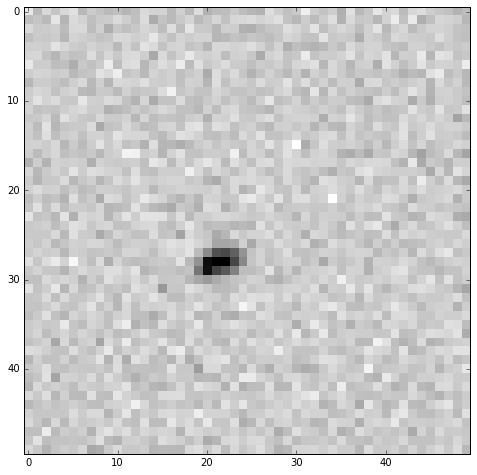

In [11]:
plt.imshow(average_feature[35])

## Decompose this 3d average feature conveyed by the cell into it's representative spatial and temporal components

In [12]:
spatial_feature, temporal_feature = decompose(average_feature)

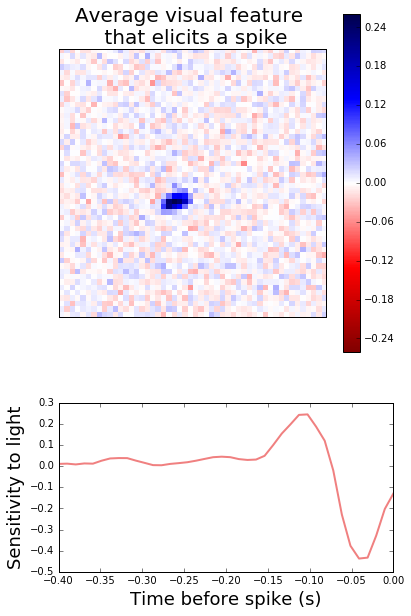

In [13]:
# plot STA
fig = plt.figure(figsize=(6,10))
filter_time = np.linspace(0.0, filter_length/sample_rate, filter_length)

# build the figure
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

# plot spatial profile
ax = fig.add_subplot(gs[0])
spatial_feature -= np.mean(spatial_feature)
maxval = np.max(np.abs(spatial_feature))
img = ax.imshow(spatial_feature, cmap='seismic_r', interpolation='nearest',
        aspect='equal', vmin=-maxval, vmax=maxval)
ax.set_xticks([])
ax.set_yticks([])
plt.colorbar(img)
plt.title('Average visual feature \n that elicits a spike', fontsize=20)

# plot temporal profile
ax = fig.add_subplot(gs[1])
ax.plot(-filter_time, temporal_feature[::-1], linestyle='-', linewidth=2, color='LightCoral')
ax.set_xlim(-filter_time[-1], filter_time[0])
plt.xlabel('Time before spike (s)', fontsize=18)
plt.ylabel('Sensitivity to light', fontsize=18)

# How linear is this cell?  
# Can we plot the actual vs predicted firing rates?

Find the nonlinearity of this cell.

#### Filter the visual stimulus with our average feature to get the predicted linear response of the cell

In [14]:
zscored_stimulus.shape

(24011, 50, 50)

In [15]:
filtered_stim = np.zeros((zscored_stimulus.shape[0]-filter_length,))
for t in range(zscored_stimulus.shape[0]-filter_length):
    filtered_stim[t] = np.inner(zscored_stimulus[t:t+filter_length].flat, average_feature.flat)
    if t % 5000 == 0:
        print('Filtered %d/%d' %(t,zscored_stimulus.shape[0]-filter_length))

Filtered 0/23971
Filtered 5000/23971
Filtered 10000/23971
Filtered 15000/23971
Filtered 20000/23971


In [16]:
whitenoise_psth.shape

(28, 24011)

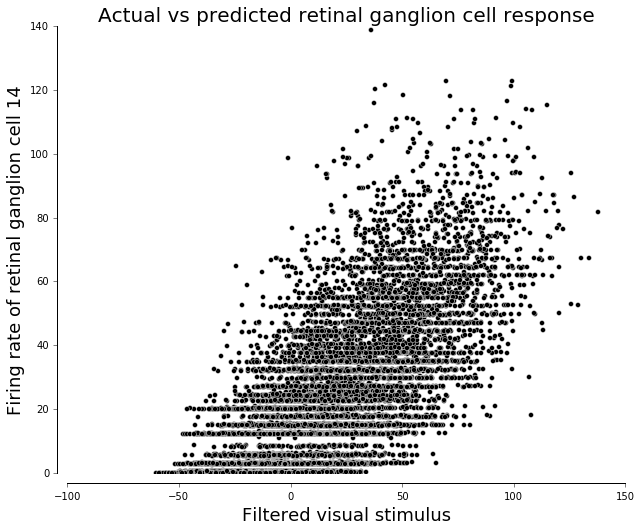

In [17]:
plt.plot(filtered_stim, whitenoise_psth[most_spiking_cell, filter_length:], 'k.', mec='w', ms=10, mew=0.4)
plt.title('Actual vs predicted retinal ganglion cell response', fontsize=20)
plt.xlabel('Filtered visual stimulus', fontsize=18)
plt.ylabel('Firing rate of retinal ganglion cell %d' %most_spiking_cell, fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## Fit nonlinearity

In [18]:
# hyperparameter
nbins = 100

# fit nonlinearity
nonlinearity = Binterp(nbins, method='linear')
nonlinearity.fit(filtered_stim, whitenoise_psth[most_spiking_cell, filter_length:])

In [19]:
nonlinearity_input = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 100)
nonlinearity_output = nonlinearity.predict(nonlinearity_input)

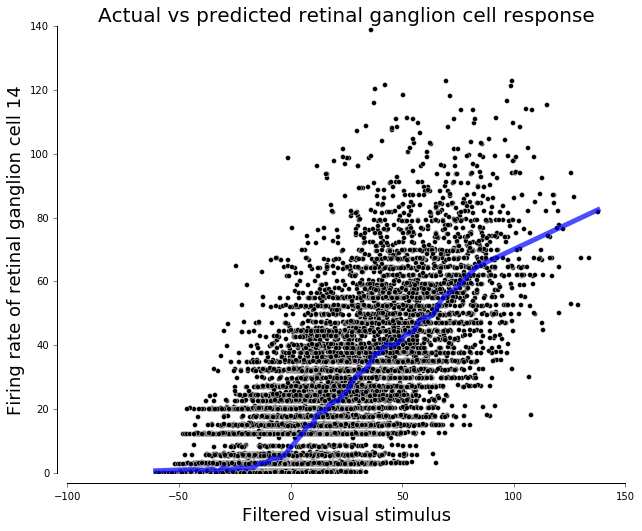

In [20]:
plt.plot(filtered_stim, whitenoise_psth[most_spiking_cell, filter_length:], 'k.', mec='w', ms=10, mew=0.4)
plt.plot(nonlinearity_input, nonlinearity_output, 'b', linewidth=5, alpha=0.7)
plt.title('Actual vs predicted retinal ganglion cell response', fontsize=20)
plt.xlabel('Filtered visual stimulus', fontsize=18)
plt.ylabel('Firing rate of retinal ganglion cell %d' %most_spiking_cell, fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## How well can a linear-nonlinear model capture retinal responses on the train set?

In [21]:
predicted_psth = nonlinearity.predict(filtered_stim)

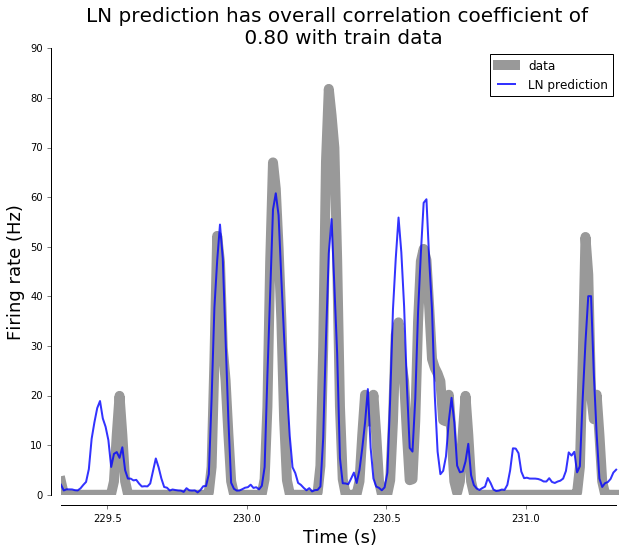

In [22]:
random_idx = np.random.choice(len(predicted_psth))
window = 200 # 100 frames is 1 second

# data
plt.plot(time[filter_length+random_idx:filter_length+random_idx+window], 
         whitenoise_psth[most_spiking_cell, filter_length+random_idx:filter_length+random_idx+window],
        'k', linewidth=10, alpha=0.4, label='data')

# LN prediction
plt.plot(time[filter_length+random_idx:filter_length+random_idx+window], 
         predicted_psth[random_idx:random_idx+window],
        'b', linewidth=2, alpha=0.8, label='LN prediction')

# compute correlation between data and prediction
LN_cc = pearsonr(whitenoise_psth[most_spiking_cell, filter_length:], predicted_psth)[0]
plt.title('LN prediction has overall correlation coefficient of \n %0.2f with train data' %LN_cc, fontsize=20)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)
plt.legend()
plt.xlim([time[filter_length+random_idx], time[filter_length+random_idx+window]])
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## How well does the LN model explain the test set?

In [23]:
# Filter test stimulus
test_zscored_stimulus = zscore(test_whitenoise_stimulus)
test_filtered_stim = np.zeros((test_zscored_stimulus.shape[0]-filter_length,))
for t in range(test_zscored_stimulus.shape[0]-filter_length):
    test_filtered_stim[t] = np.inner(test_zscored_stimulus[t:t+filter_length].flat, average_feature.flat)
    if t % 5000 == 0:
        print('Filtered %d/%d' %(t,test_zscored_stimulus.shape[0]-filter_length))
        
# Predict firing rate
test_predicted_psth = nonlinearity.predict(test_filtered_stim)
LN_test_cc = pearsonr(test_whitenoise_psth[most_spiking_cell, filter_length:], test_predicted_psth)[0]
print('LN prediction has a correlation coefficient of %0.2f with the test data.' %LN_test_cc)

Filtered 0/5960
Filtered 5000/5960
LN prediction has a correlation coefficient of 0.16 with the test data.


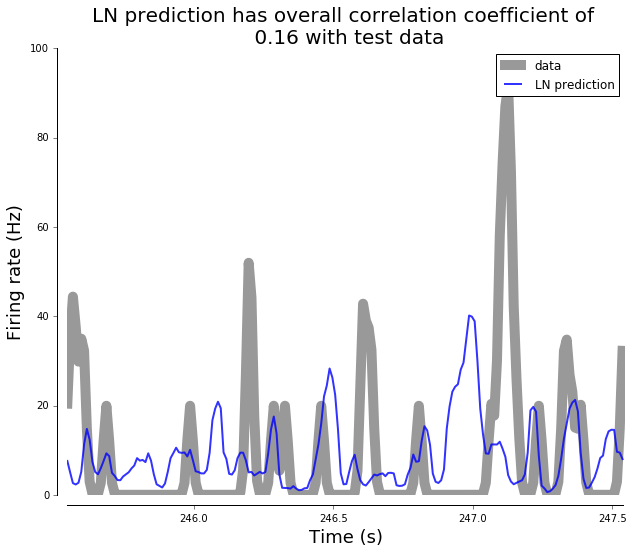

In [24]:
random_idx = np.random.choice(len(test_predicted_psth))
window = 200 # 100 frames is 1 second

# data
plt.plot(test_time[filter_length+random_idx:filter_length+random_idx+window], 
         test_whitenoise_psth[most_spiking_cell, filter_length+random_idx:filter_length+random_idx+window],
        'k', linewidth=10, alpha=0.4, label='data')

# LN prediction
plt.plot(test_time[filter_length+random_idx:filter_length+random_idx+window], 
         test_predicted_psth[random_idx:random_idx+window],
        'b', linewidth=2, alpha=0.8, label='LN prediction')

plt.title('LN prediction has overall correlation coefficient of \n %0.2f with test data' %LN_test_cc, fontsize=20)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)
plt.legend()
plt.xlim([test_time[filter_length+random_idx], test_time[filter_length+random_idx+window]])
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

# We just fit a linear-nonlinear model to a retinal ganglion cell.  

Improving the performance of an LN model on test data requires lots of regularization. We won't do this today.

## Next we will add a Poisson random variable to this model and compare it to retinal noise.  

Example raster of LN-Poisson model

In [25]:
predicted_spike_raster = poisson.rvs(predicted_psth/sample_rate)

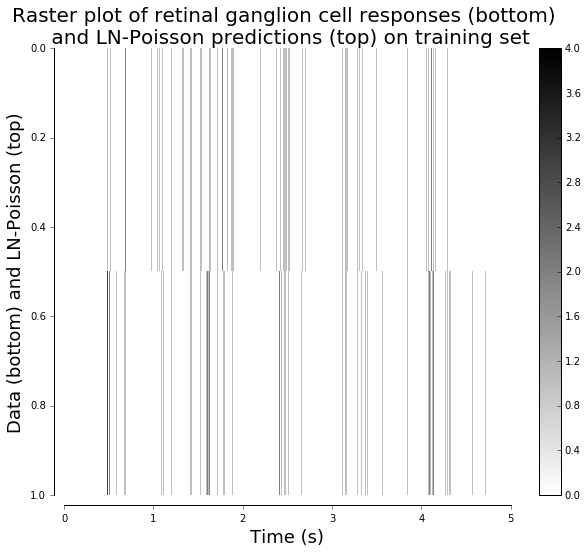

In [26]:
plt.imshow(np.stack([predicted_spike_raster, 
                     whitenoise_response[most_spiking_cell, 0, filter_length:]]), aspect='auto', cmap='gray_r', 
           extent=(time[0], time[-1], 1, 0))

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Data (bottom) and LN-Poisson (top)', fontsize=18)
plt.title('Raster plot of retinal ganglion cell responses (bottom) \n and LN-Poisson predictions (top) on training set', fontsize=20)
plt.colorbar()
plt.xlim([0,5]) # plot first 5 seconds
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

# It's difficult to tell if a Poisson assumption makes sense from just two repeats.

# Let's move to a dataset with many repeats - and one that is more natural.

## Load retinal dataset with 112 repeats of 30s natural scenes

In [27]:
with h5py.File('data/naturalscene.h5', 'r') as h:
    stimulus = np.array(np.array(h['test/stimulus']))
    psth = np.array(h['test/response/firing_rate_10ms'])
    repeats = np.stack([np.array(h['test/repeats/%s' %key]) for key in sorted(h['test/repeats'].keys())])
    time = np.array(h['test/time'])

## Visual stimulus

In [28]:
stimulus.shape

(3003, 50, 50)

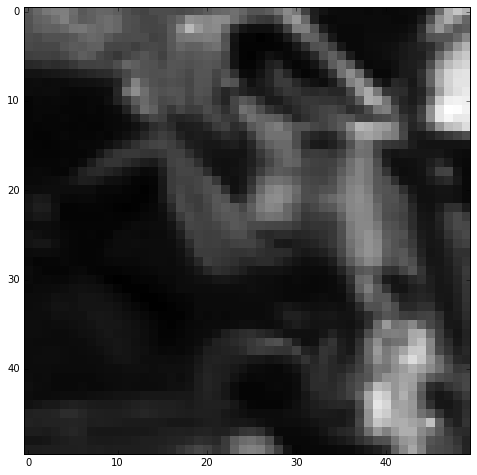

In [29]:
plt.imshow(stimulus[200])

## What does the average output of the retina look like?

In [30]:
psth.shape

(28, 3003)

#### Visualize average responses of all 28 cells for first 5 seconds of each repeat

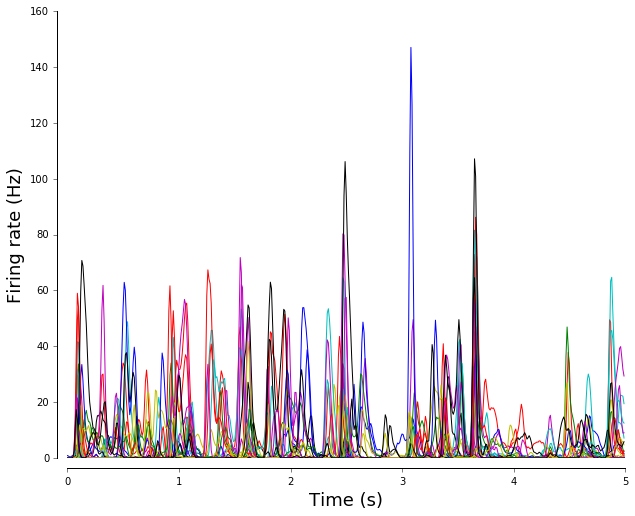

In [31]:
p = plt.plot(time[:500], psth[:,:500].T)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Qualitatively look at how change of natural scene every 1s relates to retinal firing for example cell

(0, 5)

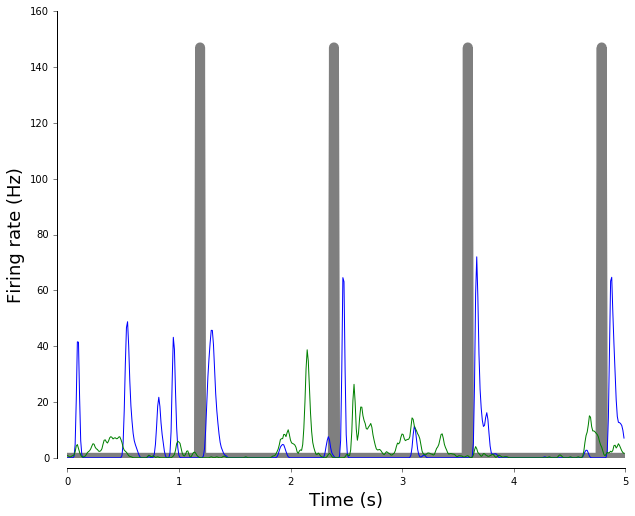

In [32]:
# Plot mean difference between frames
mean_stimulus_difference = abs(np.mean(np.diff(stimulus.astype('float32'), axis=0), axis=(1,2)))
plt.plot(time[:-1], np.max(psth)*np.where(mean_stimulus_difference > 2*np.std(mean_stimulus_difference), 1, 0), 
         'k', linewidth=10, alpha=0.5)

p = plt.plot(time[:500], psth[3,:500].T)
p = plt.plot(time[:500], psth[0,:500].T)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)

# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0,5])

## Characterizing retinal noise

In [33]:
repeats.shape

(28, 112, 3003)

#### Raster of just one cell

In [34]:
cell_id = 12

In [44]:
repeats.shape

(28, 112, 3003)

In [48]:
plt.style.use('deepretina')

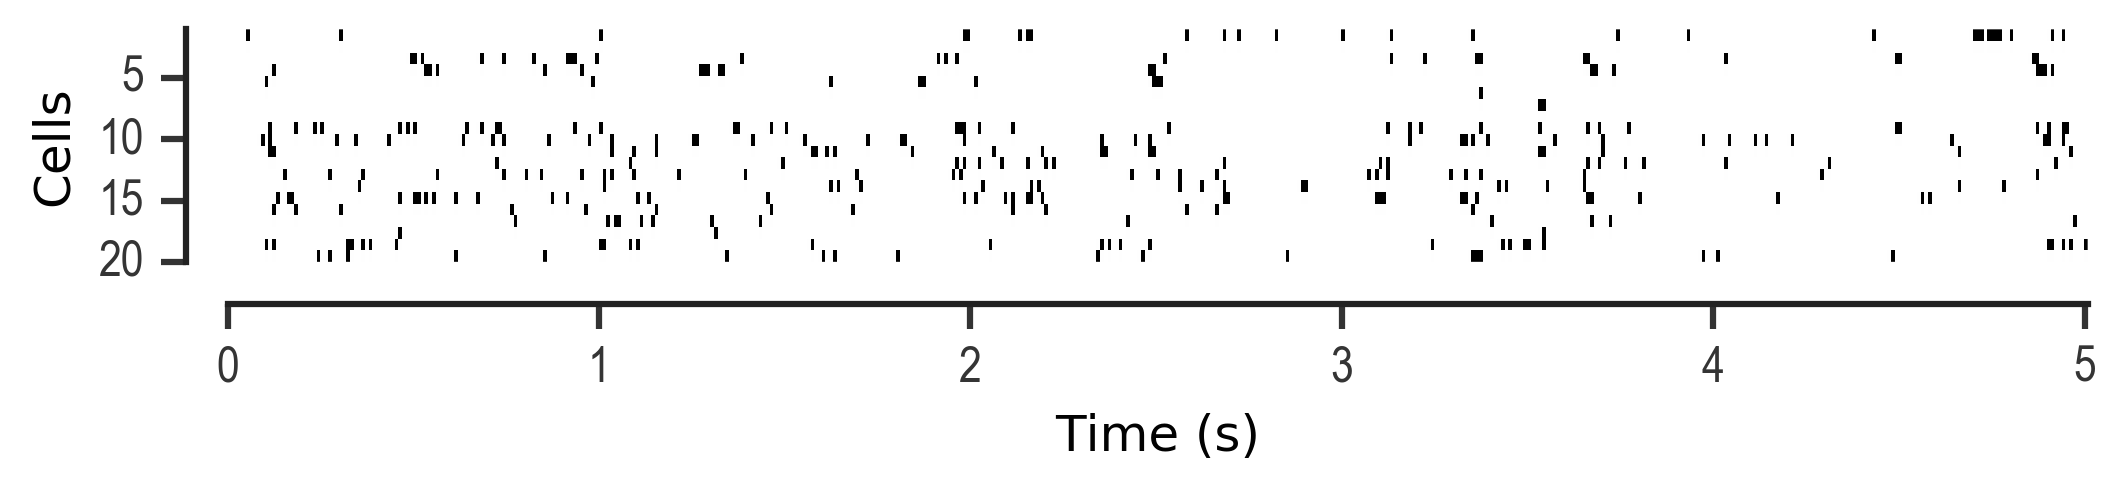

In [79]:
fig = plt.gcf()
fig.set_size_inches((8,1))
stop_index = 501
plt.imshow(np.where(repeats[:20, 0, :stop_index] > 0, 1, 0), aspect='auto', clim=[0,1], 
           cmap='gray_r', extent=(time[0], time[stop_index], repeats[:20].shape[0], 1))
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.ylabel('Cells')
plt.xlabel('Time (s)')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.savefig('deepretina raster poster.png', transparent=True)

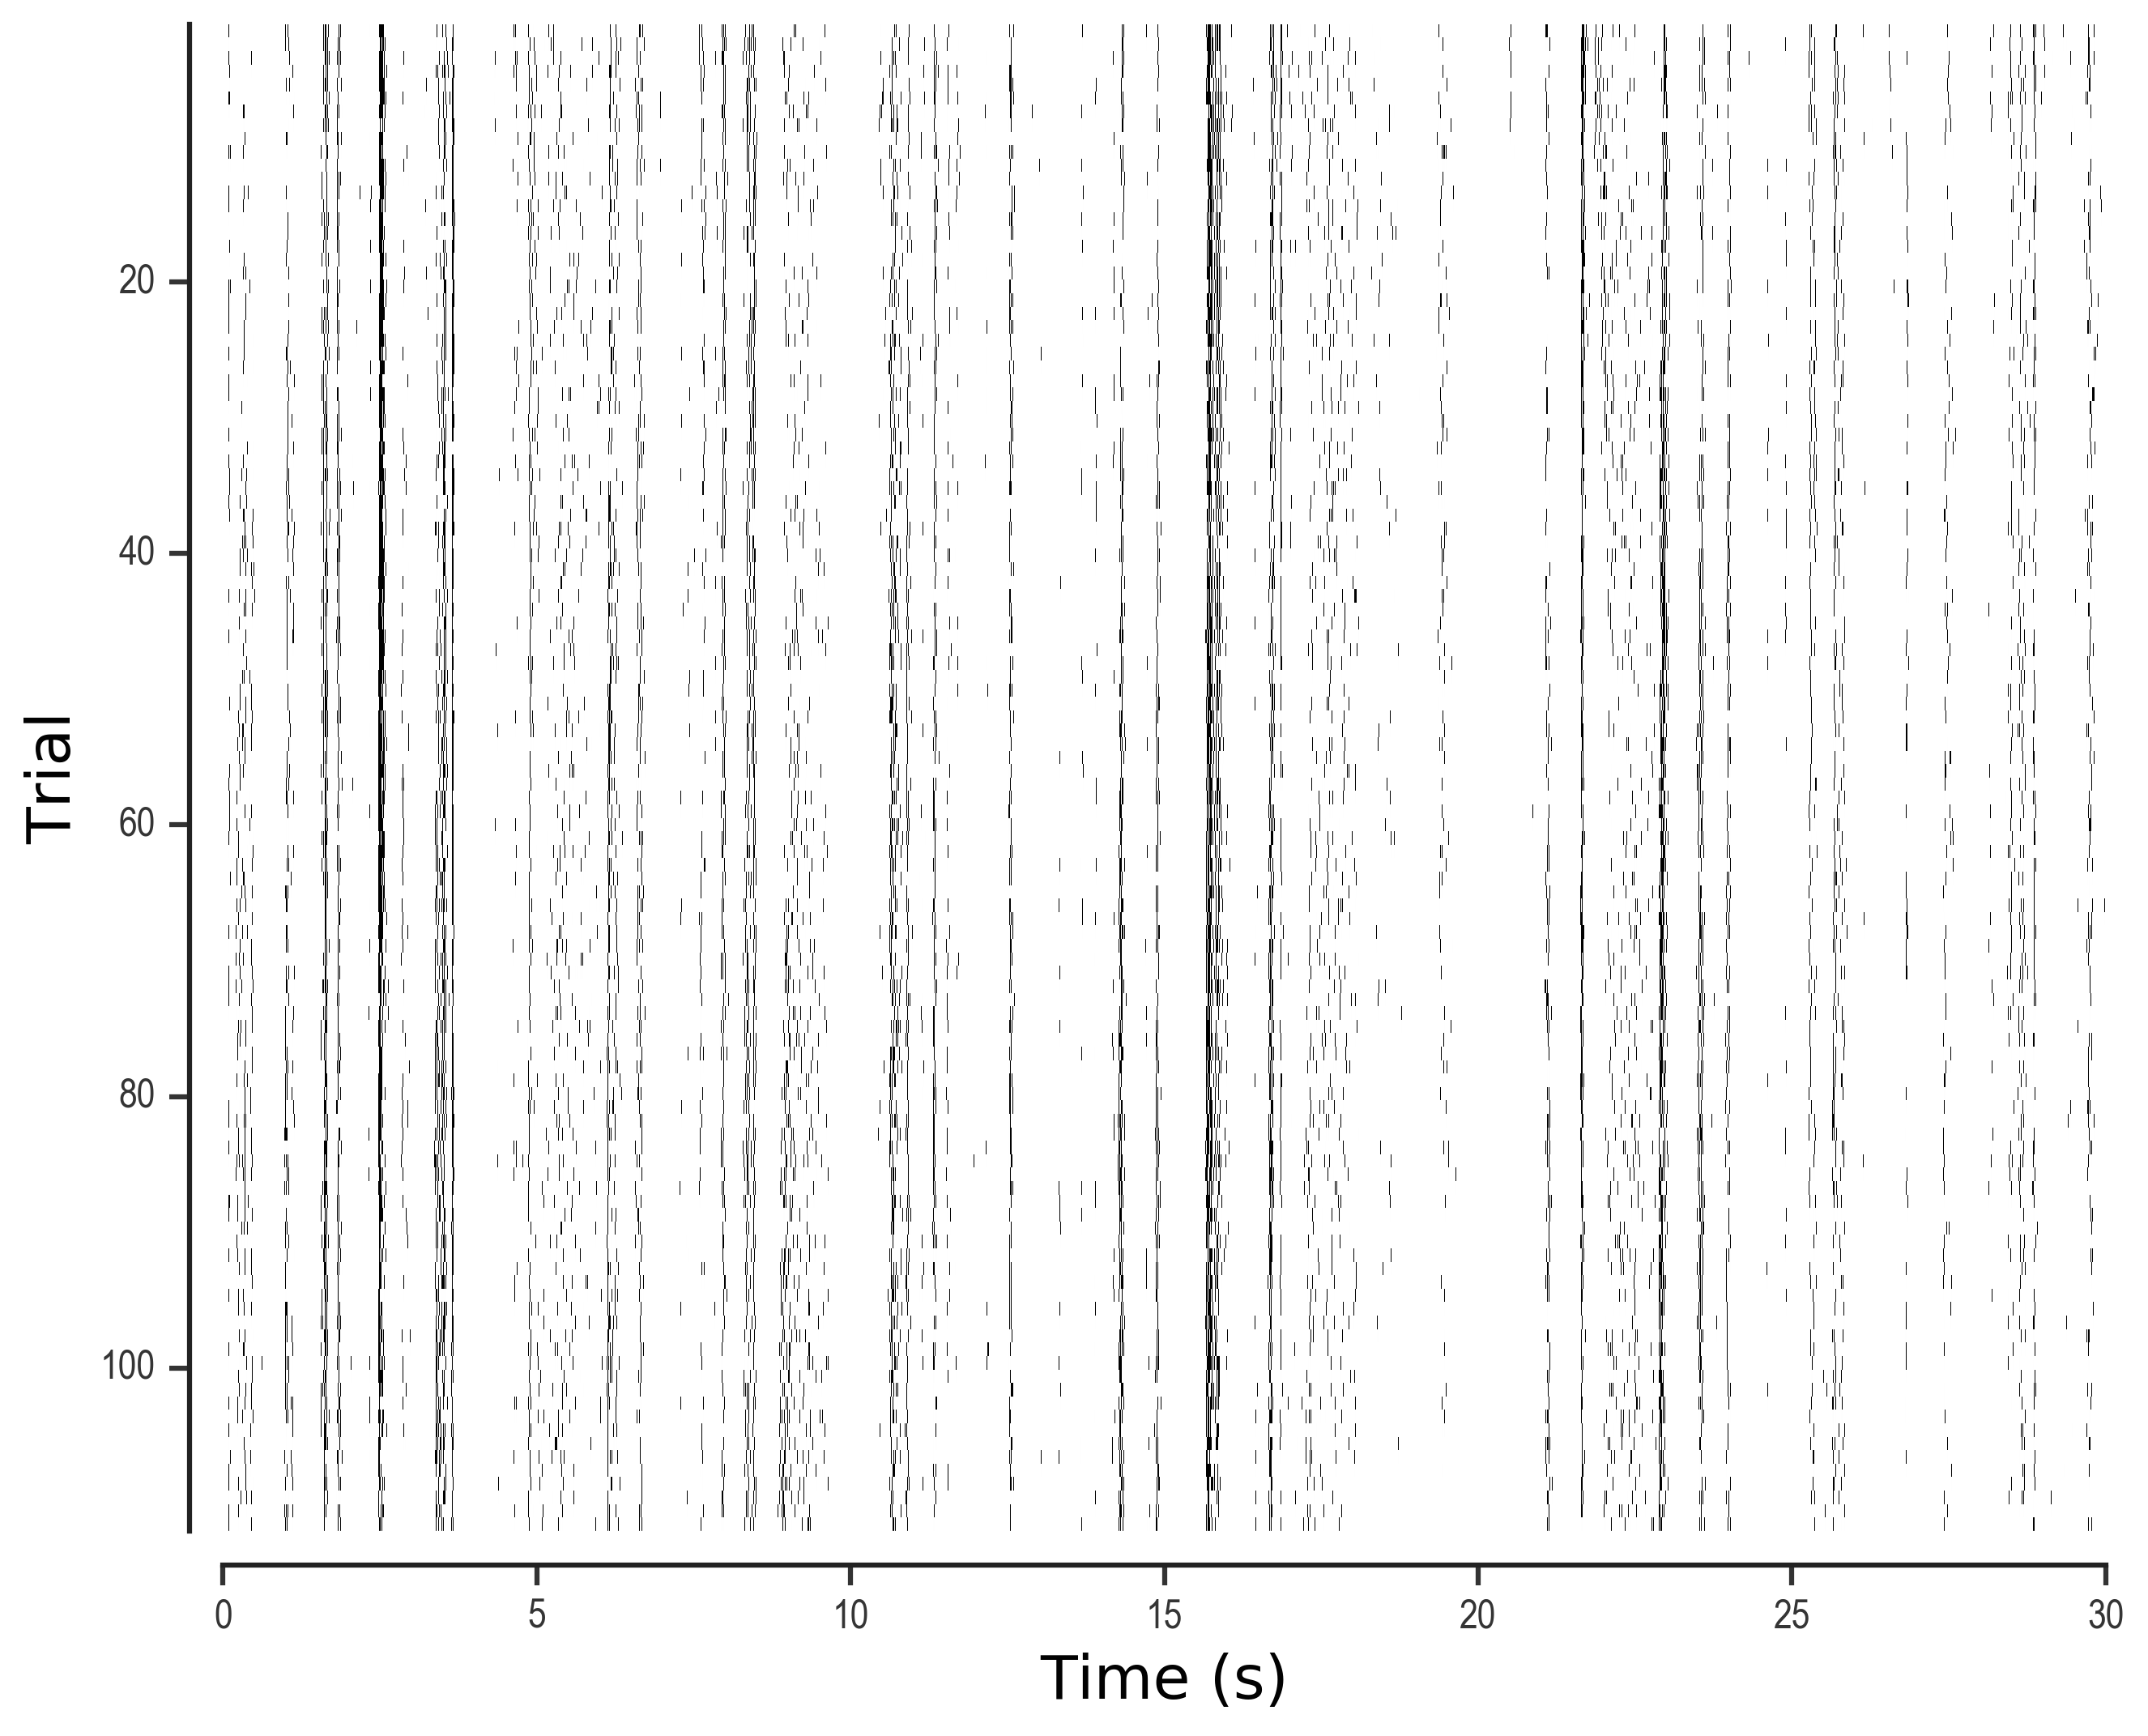

In [67]:
plt.imshow(repeats[cell_id], aspect='auto', clim=[0,1], cmap='gray_r', extent=(time[0], time[-1], repeats.shape[1], 1))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Trial', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

In [ ]:
plt.imshow(repeats[cell_id], aspect='auto', clim=[0,1], cmap='gray_r', extent=(time[0], time[-1], repeats.shape[1], 1))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Trial', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## Bin spikes into firing events

In [36]:
repeats.shape

(28, 112, 3003)

In [37]:
downsample_factor = 20
coarser_time = np.linspace(time[0],time[-1],len(time)/downsample_factor)
all_binned_spikes = []
for repeat in range(repeats.shape[1]):
    spike_times = [time[t] for t,r in enumerate(repeats[cell_id, repeat]) if r > 0]
    binned_spikes, tax = binspikes(spike_times, time=coarser_time)
    all_binned_spikes.append(binned_spikes)
coarse_repeats = np.stack(all_binned_spikes)

In [38]:
coarse_repeats.shape

(112, 149)

In [39]:
var_spike_count = np.var(coarse_repeats, axis=0)
mean_spike_count = np.mean(coarse_repeats, axis=0)

# fit a polynomial to this relationship
degree = 3
p = np.polyfit(mean_spike_count, var_spike_count, degree)
sorted_means = np.linspace(np.min(mean_spike_count), np.max(mean_spike_count), 100)
polynomial_fit = np.sum(np.stack([p[i] * sorted_means**(degree-i) for i in range(degree+1)]), axis=0)

In [40]:
print('Mean spike count is %0.2f spikes in %0.2f s bins' %(np.mean(mean_spike_count), np.mean(np.diff(coarser_time))))

Mean spike count is 0.85 spikes in 0.20 s bins


In [41]:
print('Variance of spike count is %0.2f spikes^2 in %0.2f s bins' %(np.mean(var_spike_count), np.mean(np.diff(coarser_time))))

Variance of spike count is 0.39 spikes^2 in 0.20 s bins


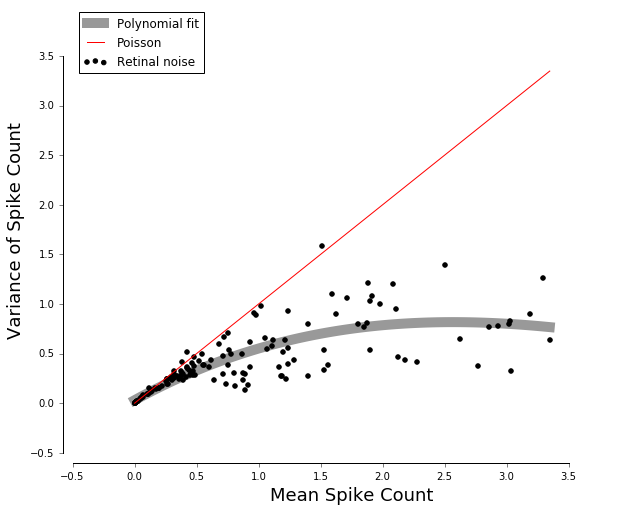

In [42]:
plt.scatter(mean_spike_count, var_spike_count, color='k', label='Retinal noise')
plt.plot(sorted_means, polynomial_fit, color='k', linewidth=10, alpha=0.4, label='Polynomial fit')
plt.plot(sorted_means, sorted_means, color='r', label='Poisson')
plt.legend(loc='upper left')
plt.xlabel('Mean Spike Count', fontsize=18)
plt.ylabel('Variance of Spike Count', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

### All cells

Error with fitting polynomial to cell 1
Error with fitting polynomial to cell 7
Error with fitting polynomial to cell 21
Error with fitting polynomial to cell 22
Error with fitting polynomial to cell 23
Error with fitting polynomial to cell 24


/Users/lmcintosh/Library/Python/3.5/lib/python/site-packages/numpy/lib/polynomial.py:588: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


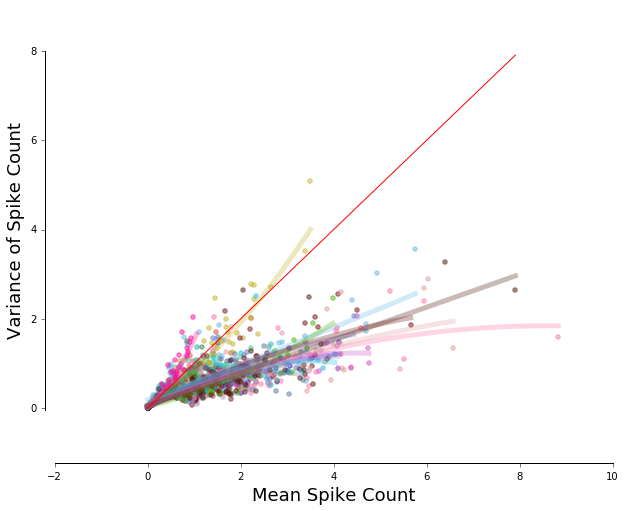

In [43]:
for cell_id in range(repeats.shape[0]):
    downsample_factor = 20
    coarser_time = np.linspace(time[0],time[-1],len(time)/downsample_factor)
    all_binned_spikes = []
    for repeat in range(repeats.shape[1]):
        spike_times = [time[t] for t,r in enumerate(repeats[cell_id, repeat]) if r > 0]
        binned_spikes, tax = binspikes(spike_times, time=coarser_time)
        all_binned_spikes.append(binned_spikes)
    coarse_repeats = np.stack(all_binned_spikes)
    
    var_spike_count = np.var(coarse_repeats, axis=0)
    mean_spike_count = np.mean(coarse_repeats, axis=0)
    
    random_color = np.random.rand(3,1)
    plt.scatter(mean_spike_count, var_spike_count, color=random_color, alpha=0.5, label='Retinal noise')
    
    # fit a polynomial to this relationship
    degree = 2
    try:
        p = np.polyfit(mean_spike_count, var_spike_count, degree)
        sorted_means = np.linspace(np.min(mean_spike_count), np.max(mean_spike_count), 100)
        polynomial_fit = np.sum(np.stack([p[i] * sorted_means**(degree-i) for i in range(degree+1)]), axis=0)
        plt.plot(sorted_means, polynomial_fit, color=random_color, linewidth=5, alpha=0.3, label='Polynomial fit')
    except:
        print('Error with fitting polynomial to cell %d' %cell_id)
        
    
plt.plot(sorted_means, sorted_means, color='r', label='Poisson')
plt.xlabel('Mean Spike Count', fontsize=18)
plt.ylabel('Variance of Spike Count', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

### This replicates a finding dating back to 1997, where retinal variability is very sub-Poisson. In fact, it hugs the lower bound of variability given that the retina has discrete firing events.

Below is a figure from Berry *et al.* 1997 showing the mean-variance response of salamander ganglion cells responding to spatially uniform random flicker at 35% contrast.

![title](img/berry1997.png)